In [19]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from estimator import RFClassifier, relu
from data_fns import noisy_sin_signal, data_matrix_non_ov, butter_bandpass_filter
import dask

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

/home/bpandey/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:39821 Dashboard: http://127.0.0.1:33897/status,Cluster Workers: 10 Cores: 70 Memory: 135.06 GB


In [103]:
def bp_weights_gaus(M, N, lowcut, highcut, fs):
    W = np.zeros((M, N))

    t_points = np.arange(N) / fs
    wk = 2 * np.pi * np.arange(lowcut, highcut + 1)
    
    c = 1 / len(wk)
    Sk = 1
    for i in range(M):
        Ak = np.random.normal(size=(len(wk), 2))
        for j, t in enumerate(t_points):
            W[i, j] = c / np.sqrt(np.pi) * np.sum(Sk * (Ak[:, 0] * np.cos(wk * t) + Ak[:, 1] * np.cos(wk * t)))
    return W.T

def bp_weights(M, N, lowcut, highcut, fs):
    J = np.random.randn(M, N)
    J = butter_bandpass_filter(J, lowcut, highcut, fs)
    return J.T

def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    # PR dimension of test data
    K = clf.transform(X_test)
    w, _ = la.eig(K.T @ K)
    PR = np.sum(w) ** 2 / np.sum(w ** 2)
    # norm of the coefficient
    clf_coef_norm = la.norm(clf.clf.coef_)
    return [PR, clf_coef_norm, 1 - clf.score(X_test, y_test)]

In [176]:
# generate data
fs, dur, sig_dur, f_signal = 2000, 200, 0.05, 35
a = 0.01
signal, label = noisy_sin_signal(f_s=fs, dur=dur, sig_dur=sig_dur, f_signal=f_signal, a=a)

delta = 0.07
N = int(delta * 2000)
X, y = data_matrix_non_ov(signal, label, N)

idx = int(len(X) * 2 / 3)
X_train, y_train = X[:idx], y[:idx]
X_test, y_test = X[idx:], y[idx:]

In [177]:
n_features = sorted(set(np.logspace(0, 3, 20).astype('int')))
print(n_features)

[1, 2, 4, 6, 8, 12, 18, 26, 37, 54, 78, 112, 162, 233, 335, 483, 695, 1000]


In [178]:
%%time 
lowcut, highcut = f_signal - 30, f_signal + 30
f = lambda M, N: bp_weights(M, N, lowcut=lowcut, highcut=highcut, fs=2000)
f_gaus = lambda M, N: bp_weights_gaus(M, N, lowcut=lowcut, highcut=highcut, fs=2000)

# band pass features
results_bp_gaus = []
results_bp = []
for n in n_features:
    params = {'width': n, 'weights': 'bandpass', 'weight_fun': f, 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_bp.append(dask.compute(*lazy_results))
    
    params = {'width': n, 'weights': 'bandpass', 'weight_fun': f_gaus, 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_bp_gaus.append(dask.compute(*lazy_results))

mean_bp = np.real(np.mean(results_bp, axis=1))
std_bp = np.real(np.std(results_bp, axis=1))

mean_bp_gaus = np.real(np.mean(results_bp_gaus, axis=1))
std_bp_gaus = np.real(np.std(results_bp_gaus, axis=1))

CPU times: user 14.6 s, sys: 3.06 s, total: 17.7 s
Wall time: 1min 26s


In [179]:
%%time 
# white noise features
results_whitenoise = []
for n in n_features:
    params = {'width': n, 'weights': 'white noise', 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_whitenoise.append(dask.compute(*lazy_results))

mean_whitenoise = np.real(np.mean(results_whitenoise, axis=1))
std_whitenoise = np.real(np.std(results_whitenoise, axis=1))

CPU times: user 6.22 s, sys: 1.55 s, total: 7.77 s
Wall time: 34.7 s


In [180]:
%%time
# gaussian features
results_gaus= []
for n in n_features:
    params = {'width': n, 'weights': 'unimodal', 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_gaus.append(dask.compute(*lazy_results))
    
mean_gaus = np.real(np.mean(results_gaus, axis=1))
std_gaus = np.real(np.std(results_gaus, axis=1))

CPU times: user 6.46 s, sys: 1.6 s, total: 8.06 s
Wall time: 34 s


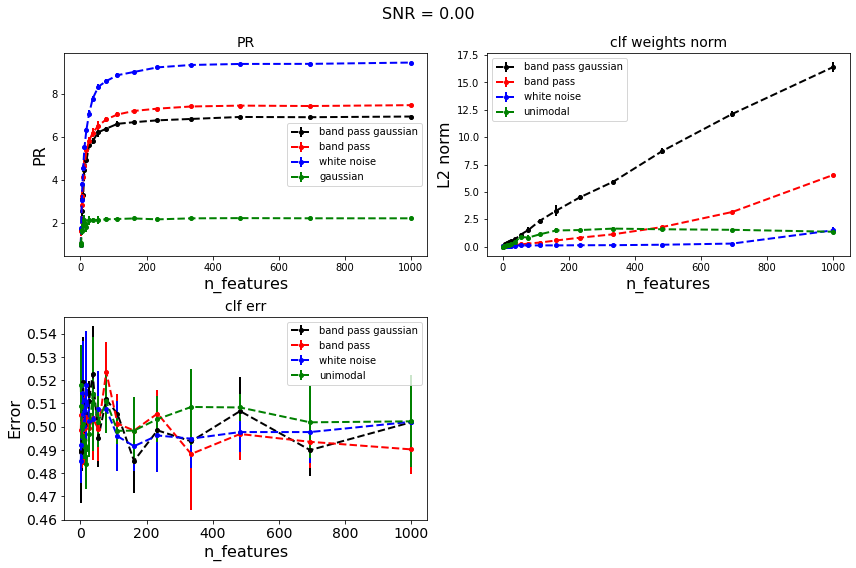

In [181]:
snr = a ** 2 / (1 - a ** 2)
# snr=1
fig = plt.figure(figsize=(12, 8))
plt.suptitle('SNR = %0.2f' % snr, fontsize=16)
ax = fig.add_subplot(221)
plt.title('PR', fontsize=14)
plt.errorbar(n_features, mean_bp_gaus[:, 0], yerr=std_bp_gaus[:, 0], fmt='--ko', label='band pass gaussian', markersize=4, lw=2)
plt.errorbar(n_features, mean_bp[:, 0], yerr=std_bp[:, 0], fmt='--ro', label='band pass', markersize=4, lw=2)
plt.errorbar(n_features, mean_whitenoise[:, 0], yerr=std_whitenoise[:, 0], fmt='--bo', label='white noise', markersize=4, lw=2)
plt.errorbar(n_features, mean_gaus[:, 0], yerr=std_gaus[:, 0], fmt='--go', label='gaussian', markersize=4, lw=2)
plt.xlabel('n_features', fontsize=16)
plt.ylabel('PR', fontsize=16)
plt.legend(fontsize=10)

ax = fig.add_subplot(222)
plt.title('clf weights norm', fontsize=14)
plt.errorbar(n_features, mean_bp_gaus[:, 1], yerr=std_bp_gaus[:, 1], fmt='--ko', label='band pass gaussian', markersize=4, lw=2)
plt.errorbar(n_features, mean_bp[:, 1], yerr=std_bp[:, 1], fmt='--ro', label='band pass', markersize=4, lw=2)
plt.errorbar(n_features, mean_whitenoise[:, 1], yerr=std_whitenoise[:, 1], fmt='--bo', label='white noise', markersize=4, lw=2)
plt.errorbar(n_features, mean_gaus[:, 1], yerr=std_gaus[:, 1], fmt='--go', label='unimodal', markersize=4, lw=2)
plt.legend(fontsize=10)
plt.xlabel('n_features', fontsize=16)
plt.ylabel('L2 norm', fontsize=16)

ax = fig.add_subplot(223)
plt.title('clf err', fontsize=14)
plt.errorbar(n_features, mean_bp_gaus[:, 2], yerr=std_bp_gaus[:, 2], fmt='--ko', label='band pass gaussian', markersize=4, lw=2)
plt.errorbar(n_features, mean_bp[:, 2], yerr=std_bp[:, 2], fmt='--ro', label='band pass', markersize=4, lw=2)
plt.errorbar(n_features, mean_whitenoise[:, 2], yerr=std_whitenoise[:, 2], fmt='--bo', label='white noise', markersize=4, lw=2)
plt.errorbar(n_features, mean_gaus[:, 2], yerr=std_gaus[:, 2], fmt='--go', label='unimodal', markersize=4, lw=2)
plt.legend(fontsize=10)
plt.xlabel('n_features', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.xlim([0, 200])

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.savefig('figures/rand_classification/gaussian_bp/clf_a=%0.2f_dim.png' % a)